In [2]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [3]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [4]:
#Create variables for the stock we are analyzing and the amount of time

ticker = "ETH-USD"
inter = "5m" #crypto has to be every 5 minutes while stocks is 1m

In [5]:
df = pd.read_csv(
    Path(f"{ticker}_prices_{inter}_January.csv"),
    parse_dates=True,
    infer_datetime_format=True)

In [6]:
df = df.set_index(pd.DatetimeIndex(df['Datetime']), drop=True, append=False, inplace=False, verify_integrity=False)

In [38]:
df

,Datetime,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,,
2022-01-06 00:00:00+00:00,2022-01-06 00:00:00+00:00,3545.65,3545.65,3536.39,3536.39,3536.39,0
2022-01-06 00:05:00+00:00,2022-01-06 00:05:00+00:00,3536.30,3538.52,3536.30,3538.47,3538.47,52967424
2022-01-06 00:10:00+00:00,2022-01-06 00:10:00+00:00,3538.58,3538.91,3535.28,3538.91,3538.91,15769600
2022-01-06 00:15:00+00:00,2022-01-06 00:15:00+00:00,3541.70,3546.87,3541.70,3546.87,3546.87,103151616
2022-01-06 00:20:00+00:00,2022-01-06 00:20:00+00:00,3544.46,3544.46,3531.40,3531.40,3531.40,405878784
...,...,...,...,...,...,...,...
2022-01-26 00:45:00+00:00,2022-01-26 00:45:00+00:00,2448.03,2448.03,2437.05,2437.05,2437.05,1313792
2022-01-26 00:50:00+00:00,2022-01-26 00:50:00+00:00,2436.73,2436.73,2432.26,2432.26,2432.26,15685632
2022-01-26 00:55:00+00:00,2022-01-26 00:55:00+00:00,2429.28,2429.28,2426.58,2427.48,2427.48,6836224


In [39]:
#This function accepts the column number for the features (X) and the target (y). It chunks the data up with a rolling window of Xt - window to predict Xt. It returns two numpy arrays of X and y.

def window_data(df, window, feature_col_number, target_col_number):

    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [40]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 25

feature_column = 4
target_column = 4
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:2]} \n")
print (f"y sample values:\n{y[:2]}")

X sample values:
[[3536.39 3538.47 3538.91 3546.87 3531.4  3534.06 3540.78 3546.69 3542.01
  3540.03 3544.24 3546.51 3540.55 3535.53 3532.08 3540.63 3539.88 3535.56
  3528.   3529.55 3530.38 3529.38 3522.68 3525.25 3523.72]
 [3538.47 3538.91 3546.87 3531.4  3534.06 3540.78 3546.69 3542.01 3540.03
  3544.24 3546.51 3540.55 3535.53 3532.08 3540.63 3539.88 3535.56 3528.
  3529.55 3530.38 3529.38 3522.68 3525.25 3523.72 3530.46]] 

y sample values:
[[3530.46]
 [3520.64]]


In [41]:
# Use 70% of the data for training and the remainder for testing
split = int(0.80 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [42]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [43]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:2]} \n")
print (f"X_test sample values:\n{X_test[:2]}")

X_train sample values:
[[[0.98910456]
  [0.99126701]
  [0.99172445]
  [1.        ]
  [0.98410091]
  [0.98697696]
  [0.9940306 ]
  [1.        ]
  [0.99558676]
  [0.99364494]
  [0.99777377]
  [1.        ]
  [0.99992274]
  [0.99507441]
  [0.9917424 ]
  [1.        ]
  [1.        ]
  [1.        ]
  [0.99760056]
  [0.9991124 ]
  [0.99992197]
  [0.99894659]
  [0.99241153]
  [0.99491826]
  [0.99342593]]

 [[0.99126701]
  [0.99172445]
  [1.        ]
  [0.98391675]
  [0.98686687]
  [0.99390609]
  [1.        ]
  [0.99541104]
  [0.99364494]
  [0.99777377]
  [1.        ]
  [0.99427633]
  [0.99507441]
  [0.9917424 ]
  [1.        ]
  [0.99927565]
  [0.99582472]
  [0.99266262]
  [0.9991124 ]
  [0.99992197]
  [0.99894659]
  [0.99241153]
  [0.99491826]
  [0.99342593]
  [1.        ]]] 

X_test sample values:
[[[ 0.01696695]
  [ 0.04007818]
  [ 0.03748947]
  [ 0.03236404]
  [-0.00845387]
  [-0.02085954]
  [-0.03008939]
  [ 0.01625745]
  [ 0.01467156]
  [ 0.01682914]
  [-0.02121295]
  [ 0.0494963 ]
  [ 0.0

In [44]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [45]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 25
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [46]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [47]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 25, 25)            2700      
                                                                 
 dropout_3 (Dropout)         (None, 25, 25)            0         
                                                                 
 lstm_4 (LSTM)               (None, 25, 25)            5100      
                                                                 
 dropout_4 (Dropout)         (None, 25, 25)            0         
                                                                 
 lstm_5 (LSTM)               (None, 25)                5100      
                                                                 
 dropout_5 (Dropout)         (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [48]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=64, verbose=1)

Epoch 1/50
71/71 [==============================] - 12s 46ms/step - loss: 0.0609
Epoch 2/50
71/71 [==============================] - 3s 45ms/step - loss: 0.0137
Epoch 3/50
71/71 [==============================] - 4s 50ms/step - loss: 0.0118
Epoch 4/50
71/71 [==============================] - 3s 46ms/step - loss: 0.0099
Epoch 5/50
71/71 [==============================] - 3s 45ms/step - loss: 0.0083
Epoch 6/50
71/71 [==============================] - 3s 46ms/step - loss: 0.0071
Epoch 7/50
71/71 [==============================] - 3s 45ms/step - loss: 0.0067
Epoch 8/50
71/71 [==============================] - 3s 45ms/step - loss: 0.0062
Epoch 9/50
71/71 [==============================] - 3s 46ms/step - loss: 0.0060:
Epoch 10/50
71/71 [==============================] - 3s 45ms/step - loss: 0.0062
Epoch 11/50
71/71 [==============================] - 3s 45ms/step - loss: 0.0054
Epoch 12/50
71/71 [==============================] - 3s 45ms/step - loss: 0.0054
Epoch 13/50
71/71 [================

In [50]:
# Make some predictions
predicted = model.predict(X_test)

In [51]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [52]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Datetime,,
2022-01-22 00:25:00+00:00,2581.76,2526.039307
2022-01-22 00:30:00+00:00,2603.26,2526.761475
2022-01-22 00:35:00+00:00,2612.93,2528.150635
2022-01-22 00:40:00+00:00,2609.67,2530.424072
2022-01-22 00:45:00+00:00,2611.34,2533.491455


In [53]:
conditions = [
    (stocks['Real'] > stocks['Predicted'].shift(periods=-1)),
    (stocks['Real'] < stocks['Predicted'].shift(periods=-1)),
    (stocks['Real'] == stocks['Predicted'].shift(periods=-1))
     ]

values = ['-1', '1', '0']

stocks['LSTM_Signal'] = np.select(conditions, values)

In [54]:
stocks

,Real,Predicted,LSTM_Signal
Datetime,,,
2022-01-22 00:25:00+00:00,2581.76,2526.039307,-1
2022-01-22 00:30:00+00:00,2603.26,2526.761475,-1
2022-01-22 00:35:00+00:00,2612.93,2528.150635,-1
2022-01-22 00:40:00+00:00,2609.67,2530.424072,-1
2022-01-22 00:45:00+00:00,2611.34,2533.491455,-1
...,...,...,...
2022-01-26 00:45:00+00:00,2437.05,2381.134277,-1
2022-01-26 00:50:00+00:00,2432.26,2382.755127,-1
2022-01-26 00:55:00+00:00,2427.48,2383.929199,-1


<AxesSubplot:xlabel='Datetime'>

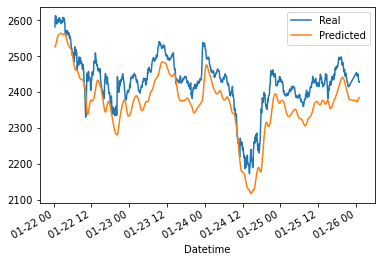

In [55]:
# Plot the real vs predicted prices as a line chart
stocks.plot()

In [56]:
model.evaluate(X_test, y_test)

36/36 [==============================] - 3s 12ms/step - loss: 0.0038


0.0037693313788622618

In [57]:
stocks.to_csv("LSTM_signal_Jan.csv")